In [6]:
from google.colab import drive
from keras.utils.vis_utils import plot_model as plot
import os
import numpy as np


drive.mount('/content/gdrive/', force_remount=True)

fullPath  = '/content/gdrive/My Drive/Code/LPR/'
#dataName  = 'dataset_3_icdar/'
dataName  = 'dataset_4/'
os.chdir(fullPath)
print(os.getcwd())


print('[INFO] Libraries loaded ...')


Mounted at /content/gdrive/
/content/gdrive/My Drive/Code/LPR
[INFO] Libraries loaded ...


In [7]:
%load_ext autoreload
%autoreload 2

from DualDisBCD import *
from img_utils  import *
from bwmorph_thin import *
from pfmeasure  import pfmeasure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Initiliaze The Model**

In [8]:

# Set  1 (Image Size: 256, 128)
image_shape_gen = (128, 256, 3)
image_shape_dis = (128, 256, 1)
patch_size      = (8, 16)

"""
# Set 2 (Image Size: 128, 128)
image_shape_gen = (128, 128, 3)
image_shape_dis = (128, 128, 1)
patch_size      = (8, 8)
"""

#bs             = 22/19/25
bs              = 15
model_dir       = fullPath + dataName + 'models'
path_X          = fullPath + dataName + 'train/train_org'
path_Y          = fullPath + dataName + 'train/train_bin'

image_size      = (image_shape_gen[1], image_shape_gen[0])
print('Image Size ', image_size)


# Loss Details
#'binary_crossentropy'/ 'mae'/ mssim/ wloss/ accw
gen_loss      = [mssim, 'binary_crossentropy']
gen_loss_wght = [100, 100]



Image Size  (256, 128)


Patch Size ( 8 x 4 )
No of Generator losses: 2
Loss Functions: [<function mssim at 0x7fbd2a9140d0>, 'binary_crossentropy']
Loss Weights:   [100, 100]


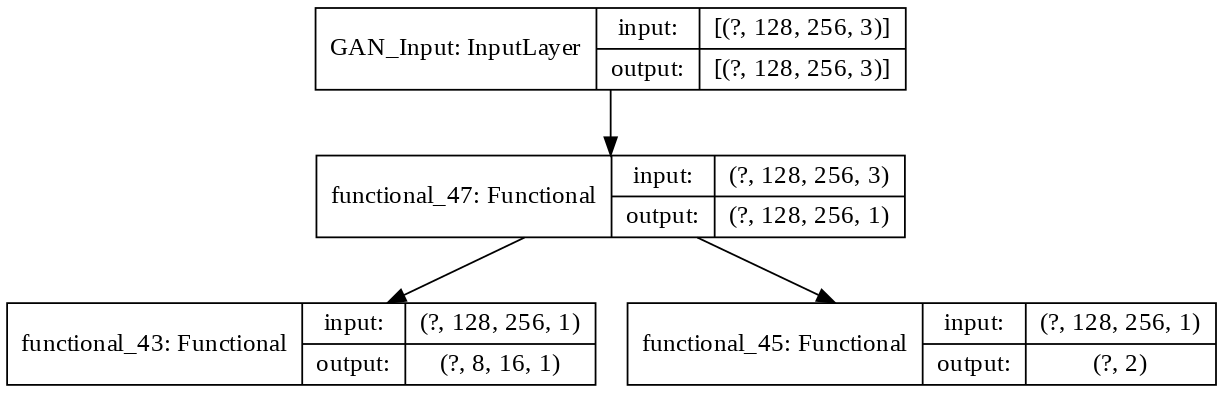

In [ ]:
gan = DualDisScaledGAN(image_shape_gen, 
                       image_shape_dis, 
                       patch_size, bs,
                       gen_loss, gen_loss_wght)
#gan.feed_data(path_X, path_Y)

#print(gan.gan_model.summary())
#print(gan.gan_model.metrics_names)
#plot(gan.d_model1, show_shapes=True, dpi=64, rankdir="LR")
plot(gan.gan_model, show_shapes=True, dpi=128, to_file="gan_model.png")

In [ ]:
gan.run(model_dir, no_epoch=80)

>> epoch 00 batch 00 d1[0.060] d2[1.387] g[0.464] gan[[47.994144439697266, 1.8366488218307495, 0.6940509080886841, 0.2714827358722687, 0.19233499467372894]]
>> epoch 00 batch 01 d1[0.060] d2[1.387] g[0.302] gan[[31.95640754699707, 2.0275168418884277, 0.6934827566146851, 0.19833265244960785, 0.10415899753570557]]
>> epoch 00 batch 02 d1[0.059] d2[1.387] g[0.388] gan[[40.379783630371094, 1.8178447484970093, 0.6936907172203064, 0.23921626806259155, 0.1485554277896881]]
>> epoch 00 batch 03 d1[0.057] d2[1.390] g[0.281] gan[[29.78946876525879, 1.9070193767547607, 0.6939215064048767, 0.18427562713623047, 0.09714475274085999]]
>> epoch 00 batch 04 d1[0.060] d2[1.390] g[0.409] gan[[42.26800537109375, 1.419941782951355, 0.693423330783844, 0.23856407403945923, 0.17008206248283386]]
>> epoch 00 batch 05 d1[0.063] d2[1.387] g[0.342] gan[[35.553443908691406, 1.4100803136825562, 0.694580078125, 0.2026546597480774, 0.138883575797081]]
>> epoch 00 batch 06 d1[0.058] d2[1.388] g[0.328] gan[[34.31050872

KeyboardInterrupt: ignored

In [ ]:
import os
import cv2
import numpy as np
from keras import models

test_dir        = fullPath + dataName + 'test/test_org'
output_test_dir = fullPath + dataName + '1_output'
model_path      = fullPath + dataName + 'models/BCDUnet_gan_gen_50.h5'

def predict_output(test_dir, output_test_dir):
  count = 0

  #model = models.load_model(model_path)
  model = models.load_model(model_path, custom_objects={"mssim":mssim})

  for file in os.listdir(test_dir):
    #if 'blur' in file:
      #continue

    img_x = cv2.imread(os.path.join(test_dir, file)) 
    img_x = cv2.resize(img_x, image_size, interpolation = cv2.INTER_CUBIC)
    img_x = np.array([img_x]).astype('float32')/255

    img_output = model.predict(img_x)
    img_output = img_output * 255
    img_output = img_output.astype('uint8')

    cv2.imwrite(os.path.join(output_test_dir, file), img_output[0])

    # Log  
    if count % 30 == 0:
        print("\nTest Count: %03d"%count, end='')    
    print('.', end='')   
    count += 1

predict_output(test_dir, output_test_dir)


Test Count: 000..............................
Test Count: 030..............................
Test Count: 060..............................
Test Count: 090..............................
Test Count: 120..............................

**Single Image Testing**

In [23]:
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
from keras import models

imageName    = fullPath + dataName + 'test/ss.PNG'
outFileName  = fullPath + dataName + 'test/cropped_out.png'
model_path   = fullPath + dataName + 'models/BCDUnet_gan_gen.h5'

model = models.load_model(model_path, custom_objects={"mssim":mssim})


img_x = cv2.imread(imageName) 
print(img_x.shape)
img_x = cv2.resize(img_x, image_size, interpolation = cv2.INTER_CUBIC)
img_x = np.array([img_x]).astype('float32')/255

print(img_x.shape)

img_output = model.predict(img_x)
img_output = img_output * 255
img_output = img_output.astype('uint8')

mask, img_out_th = clean_image_1(cv2.resize(img_output[0], (256,128)), 125)

cv2.imwrite(outFileName, cv2.resize(img_out_th, (256,128))) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(50, 140, 3)
(1, 128, 256, 3)


True

In [ ]:

%load_ext autoreload
%autoreload 2

from img_utils  import *

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity  as compare_ssim
from sklearn.metrics import precision_score, f1_score
from scipy import ndimage

output_dir  = fullPath + dataName + '1_output'
gt_dir      = fullPath + dataName + 'test/test_bin_3'
save_dir    = fullPath + dataName + '1_ul_output/'

ssim_thresh    = []
sim            = []
sim_thresh     = []
prcsn_thresh   = []
psnr_thresh   = []
fscore_thresh  = []
pfscore_thresh = []
drd_thresh     = []

def similarity_index(img1, img2):
  return np.sum(np.array(img1) == np.array(img2)) / np.array(img1).size

def bilateral_filter(img, filter_size=15):
  out     = cv2.bilateralFilter(img, filter_size, 75, 75) 
  _, out = cv2.threshold(out, 127, 255, cv2.THRESH_BINARY)
  return out

def grayscale_dialation(img):
  gray_dial = ndimage.grey_dilation(img, size=(5,5), structure=np.ones((5, 5)))
  _, gray_dial = cv2.threshold(gray_dial,245,255,cv2.THRESH_BINARY)
  return gray_dial

count   = 0
invalidCounter = 0
divisor = 255

for filename in sorted(os.listdir(output_dir)):
    #if 'blur' in filename:
      #continue
    #print(filename)

    # Image Read
    img_gt  = cv2.resize(cv2.imread(os.path.join(gt_dir, filename), cv2.IMREAD_GRAYSCALE) ,  
                          image_size, interpolation = cv2.INTER_CUBIC)
    img_out = cv2.resize(cv2.imread(os.path.join(output_dir, filename), cv2.IMREAD_GRAYSCALE), 
                          image_size, interpolation = cv2.INTER_CUBIC)

    # Image Thresholding/ Clean
    _, img_gt_th  = cv2.threshold(img_gt, 127, 255, cv2.THRESH_BINARY)
    #_, img_out_th = cv2.threshold(img_out, 127, 255, cv2.THRESH_BINARY)

    #img_out_th    = bilateral_filter(img_out, 25)
    mask, img_out_th = clean_image_1(img_out, 125)
    #mask, img_out_th  = clean_image_2(img_out_th, 125)
    

    # Image write
    cv2.imwrite(os.path.join(save_dir, filename), img_out_th) 

    # Log Print
    if count == 300:
      print_images([img_out, img_gt, img_out_th, img_gt_th, mask],
                   ['out',   'gt',   'out_th',   'gt_th', 'mask'])      
      break
    # Log  
    if count % 30 == 0:
        print("\nTest Count: %03d"%count, end='')    
    print('.', end='')
    count += 1

    #img_out_th = img_out
    #img_gt_th  = img_gt

    psnr_value = compare_psnr(img_out_th, img_gt_th, data_range=255)

    """
    if  psnr_value < 13 and count > 1:      
      print("\n")
      psnr_value_prev = psnr_value
      #print_images([img_out, img_gt, img_out_th, img_gt_th, mask], ['out',   'gt',   'out_th',   'gt_th', 'mask'])       
      #img_out_th = grayscale_dialation(img_out)
      #psnr_value = compare_psnr(img_out_th, img_gt_th, data_range=255)
      print(count, filename, psnr_value_prev, '-->', psnr_value)
      
      #print_images([img_out, img_gt, img_out_th, img_gt_th, mask], ['out',   'gt',   'out_th',   'gt_th', 'mask']) 
      #break
    """

    average_type = 'binary'
    psnr_thresh.append(psnr_value)
    ssim_thresh.append(compare_ssim(img_out_th, img_gt_th))
    sim_thresh.append(similarity_index(img_out_th, img_gt_th))
    prcsn_thresh.append(precision_score(np.array(img_out_th/divisor).astype('uint8').flatten(), 
                                        np.array(img_gt_th/divisor).astype('uint8').flatten(), 
                                        average=average_type))
    fscore_thresh.append(f1_score(np.array(img_out_th/divisor).astype('uint8').flatten(),       
                                  np.array(img_gt_th/divisor).astype('uint8').flatten(), 
                                  average=average_type))
    pfscore_thresh.append(pfmeasure(np.array(img_out_th/255).astype('uint8'),
                                    np.array(img_gt_th/255).astype('uint8')))
    

# Log the Result
print('\nType   | \tPSNR\tSSIM\tSimilarity\tPrecision\tF-Score\t\tPF-Score')
print('------------------------------------------------------------------------------------')
 
print('Thresh |' + 
      '\t{:.3f}'.format(sum(psnr_thresh)/len(psnr_thresh)) + 
      '\t' + '{:.3f}'.format(sum(ssim_thresh)/len(ssim_thresh)) +
      '\t{:.3f}'.format(sum(sim_thresh)/len(sim_thresh)) +
      '\t\t{:.3f}'.format(sum(prcsn_thresh)/len(prcsn_thresh)) +
      '\t\t{:.3f}'.format(sum(fscore_thresh)/len(fscore_thresh)) +
      '\t\t{:.3f}'.format(sum(pfscore_thresh)/len(pfscore_thresh))
      )

ModuleNotFoundError: ignored